# Filtri

In [313]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.signal import find_peaks
from scipy.signal import filtfilt, freqz, tf2zpk
from scipy.signal import butter, sosfiltfilt, sosfreqz, sos2zpk
import yulewalker as yw

In [314]:
def plot_dft(freqs, amplitudes, title):
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, amplitudes)
    plt.title(f'FFT of {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.xlim(0, 5000)
    plt.show()

In [315]:
# def plot_filter_response(sos, fs, title):
#     w, h = freqz(sos[:,0], sos[:,1], worN=2000, fs=fs)
#     plt.figure(figsize=(8,4))
#     plt.plot(w, 20*np.log10(abs(h)))
#     plt.title(f'Frequency response: {title}')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Amplitude [dB]')
#     plt.grid(True)
#     plt.show()

In [316]:
def find_fundamental(freqs, amplitudes):
    max_index = np.argmax(amplitudes)
    return freqs[max_index]

In [317]:
def comb_filter(sample_rate, f0, harmonics, order=25, width=50, min_freq=500, delta=5):
    np.int = np.int64
    nyq = sample_rate // 2

    intervals = []
    for h in harmonics:
        fh = h * f0
        # if fh < fmin:
        #     continue

        f1 = max(0, fh - width)
        f2 = min(nyq, fh + width)
        intervals.append((f1, f2))

    # zdruzi prekrivajoče intervale
    intervals.sort()
    merged = []
    cur_start, cur_end = intervals[0]

    for f1, f2 in intervals[1:]:
        if f1 <= cur_end + 2 * delta:
            cur_end = max(cur_end, f2)
        else:
            merged.append((cur_start, cur_end))
            cur_start, cur_end = f1, f2
    merged.append((cur_start, cur_end))

    fc = [0.0]
    am = [1.0]
    for f1, f2 in merged:
        left = max(0, f1 - delta)
        right = min(nyq, f2 + delta)

        fc.extend([left, f1, f2, right])
        am.extend([1.0, 0.0, 0.0, 1.0])

    fc.append(nyq)
    am.append(1.0)

    fc = np.array(fc)
    am = np.array(am)

    # print("Intervali notch filtrov:", merged)
    # print("Frekvence notch območij:", fc)
    # print("Amplituda notch območij:", am)

    normalized_freqs = fc / sample_rate * 2

    a, b = yw.yulewalk(order, normalized_freqs, am)

    z, p, k = tf2zpk(b, a)
    # če so poli znotraj knožnice je stabilen
    if np.any(np.abs(p) > 1):
        print("Filter ni stabilen")

    return b, a


In [318]:
def cascade_filter(sample_rate, f0, harmonics, order=4, width=10, fmin=500):
    nyq = sample_rate // 2
    sos_sections = []

    for h in harmonics:
        fh = h * f0
        # if fh < fmin or fh + width >= nyq:
        #     continue

        # + normalizacija
        low = max(0, fh - width) / nyq
        high = min(nyq, fh + width) / nyq

        sos = butter(order, [low, high], btype="bandstop", output="sos")

        sos_sections.append(sos)

    # Združi vse SOS v enega
    sos_total = np.vstack(sos_sections)

    z, p, k = sos2zpk(sos_total)
    if np.any(np.abs(p) > 1):
        print("Filter ni stabilen")

    return sos_total

In [319]:
def plot_filter_response(filter_data, sample_rate, title, type="comb"):
    if type == "comb":
        b, a = filter_data
        w, h = freqz(b, a, worN=2048, fs=sample_rate)
    elif type == "cascade":
        w, h = sosfreqz(filter_data, worN=2048, fs=sample_rate)

    plt.figure(figsize=(10, 4))
    plt.plot(w, 20 * np.log10(np.abs(h) + 1e-10))
    plt.title(title)
    plt.xlim(0, 2000)
    plt.xlabel("Frekvenca")
    plt.ylabel("Amplituda")
    plt.grid()
    plt.tight_layout()
    plt.show()
#
# def plot_filter_response(filter_data, sample_rate, title, type="comb"):
#     plt.figure(figsize=(10, 5))
#     plt.xlim(0, 2000)
#
#     if type == "comb":
#         b, a = filter_data
#         w, h = freqz(b, a, worN=2048, fs=sample_rate)
#
#         # --- Amplitudni odziv ---
#         plt.subplot(2, 1, 1)
#         plt.plot(w, 20 * np.log10(np.abs(h) + 1e-10), 'b')
#         plt.title(title + " - Amplitudni odziv")
#         plt.xlabel("Frekvenca [Hz]")
#         plt.ylabel("Amplituda [dB]")
#         plt.grid(True)
#
#         # --- Fazni odziv ---
#         plt.subplot(2, 1, 2)
#         plt.plot(w, np.angle(h), 'r')
#         plt.title(title + " - Fazni odziv")
#         plt.xlabel("Frekvenca [Hz]")
#         plt.ylabel("Faza [rad]")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()
#
#     elif type == "cascade":
#         # samo amplituda za SOS
#         w, h = sosfreqz(filter_data, worN=2048, fs=sample_rate)
#         plt.plot(w, 20 * np.log10(np.abs(h) + 1e-10), 'b')
#         plt.title(title + " - Amplitudni odziv (cascade)")
#         plt.xlabel("Frekvenca [Hz]")
#         plt.ylabel("Amplituda [dB]")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()



Najdena bazna frekvenca: 87.44776119402985 Hz


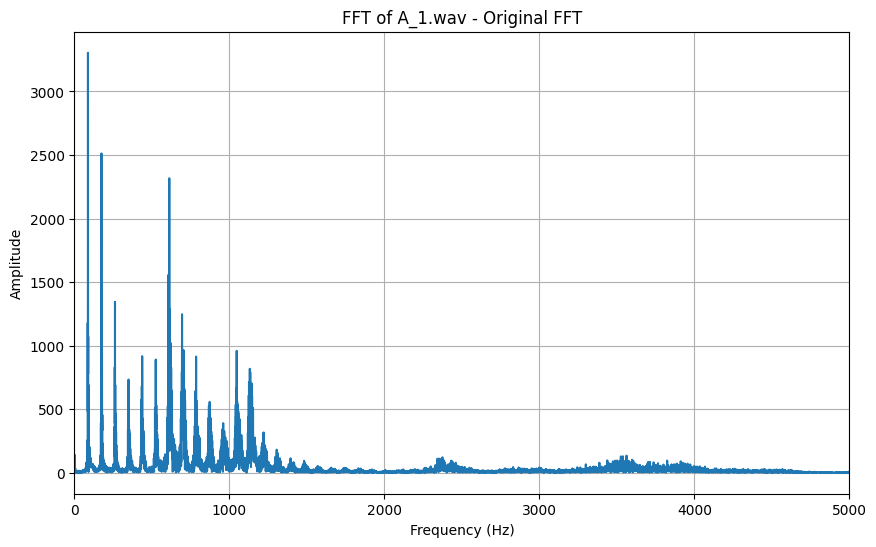

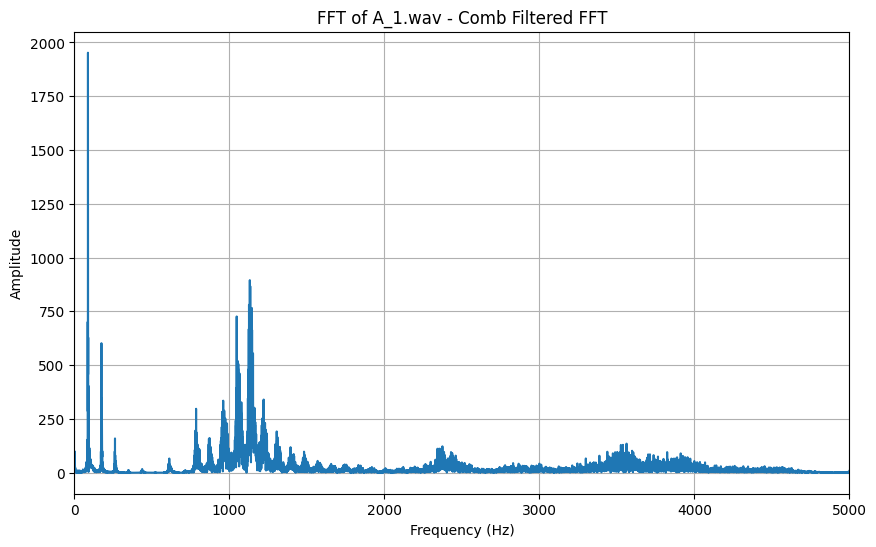

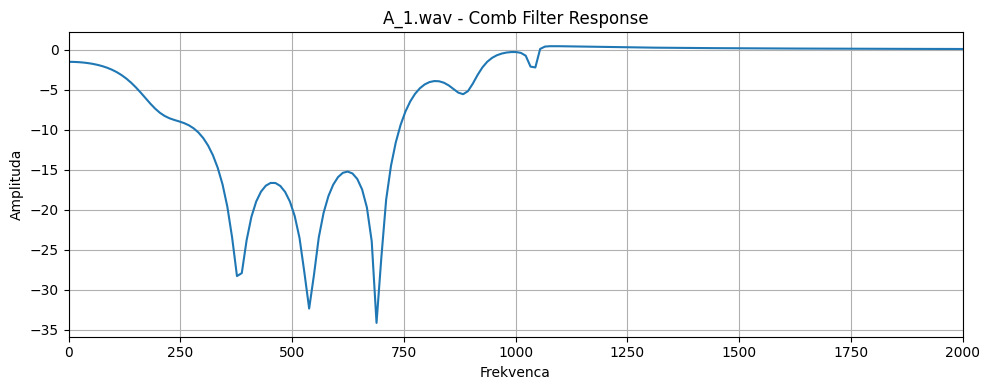

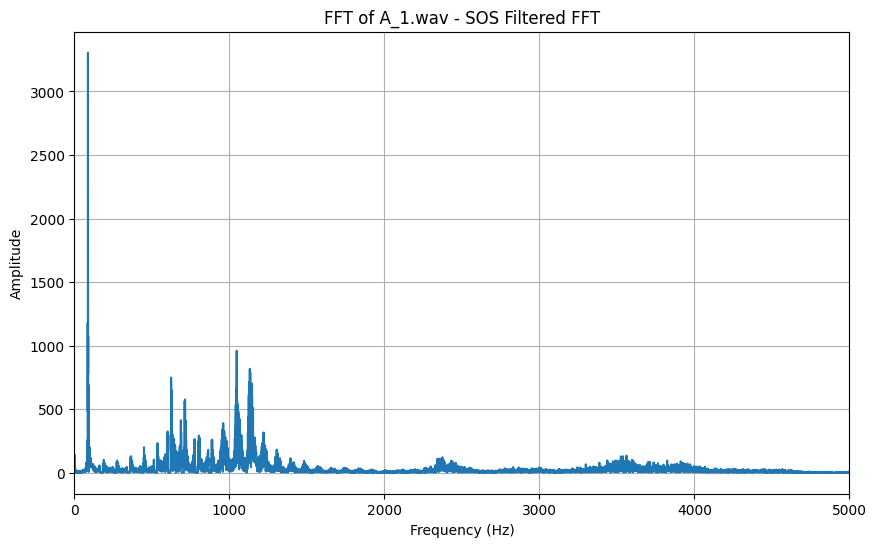

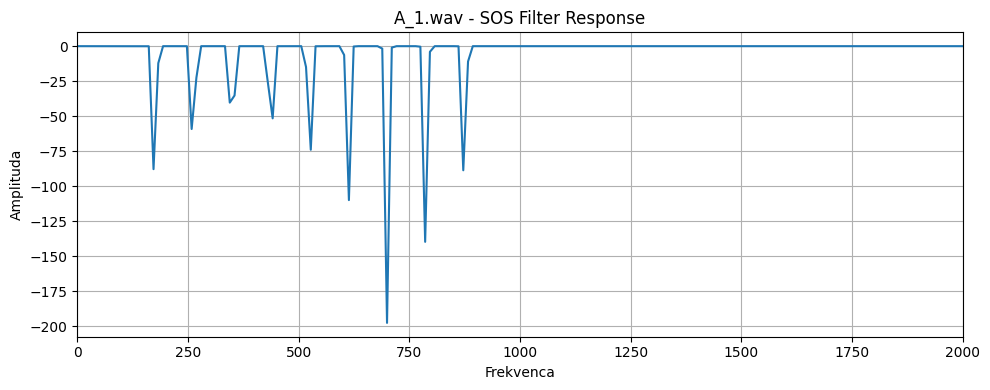

------------------------------------------------------------------------------------------
Najdena bazna frekvenca: 79.30874050480016 Hz


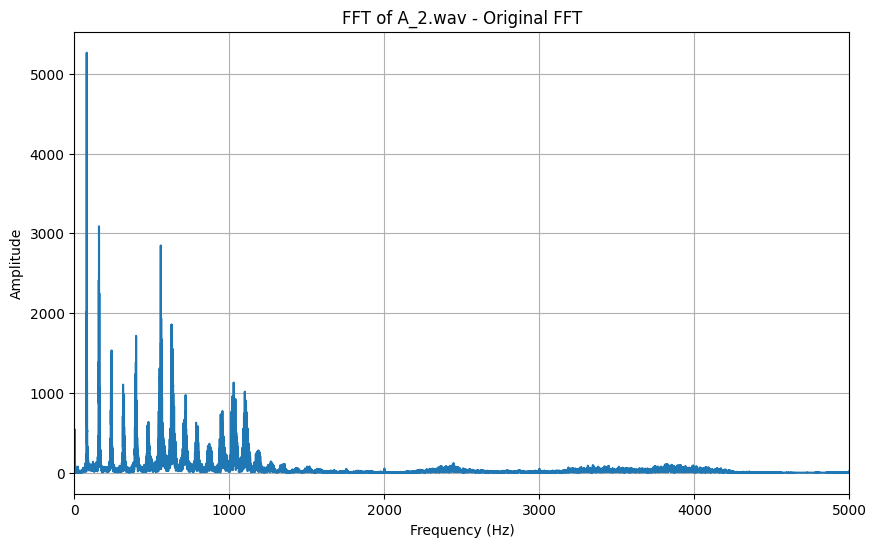

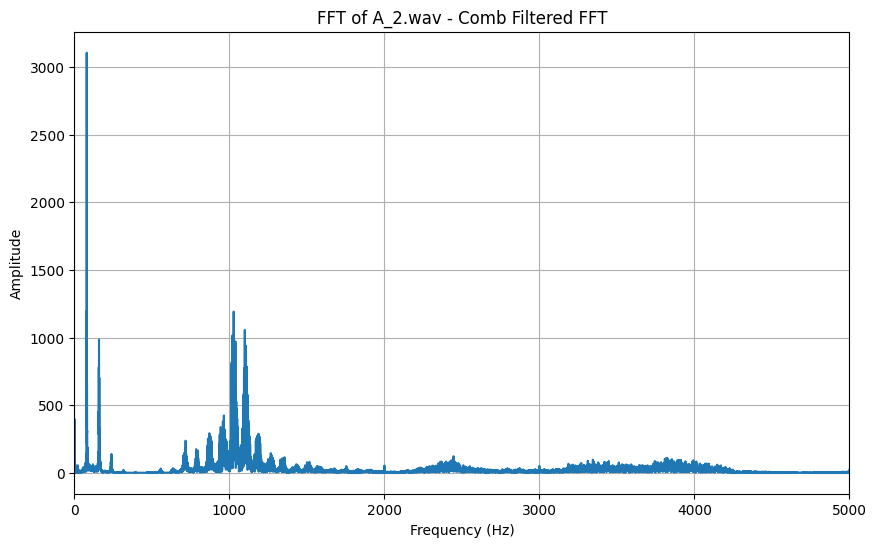

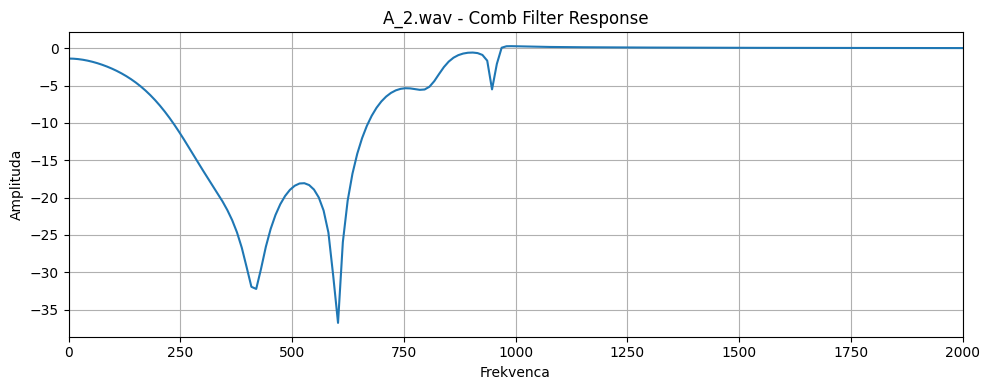

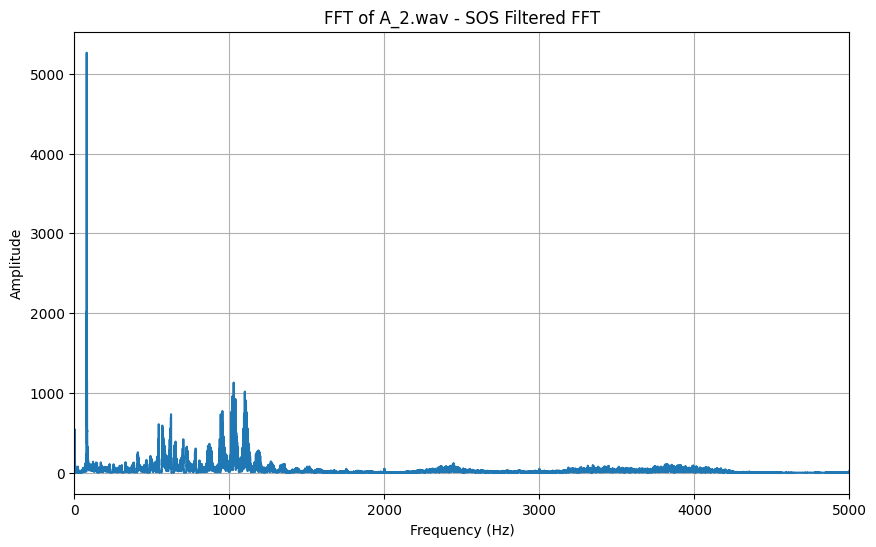

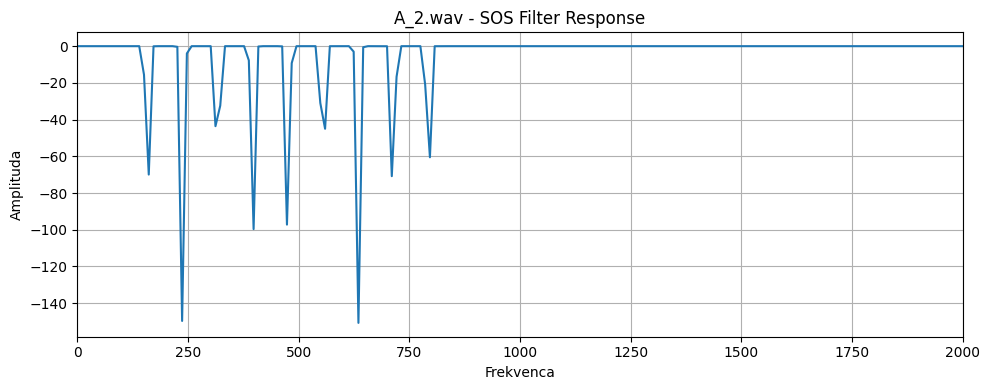

------------------------------------------------------------------------------------------
Najdena bazna frekvenca: 268.2019614965492 Hz


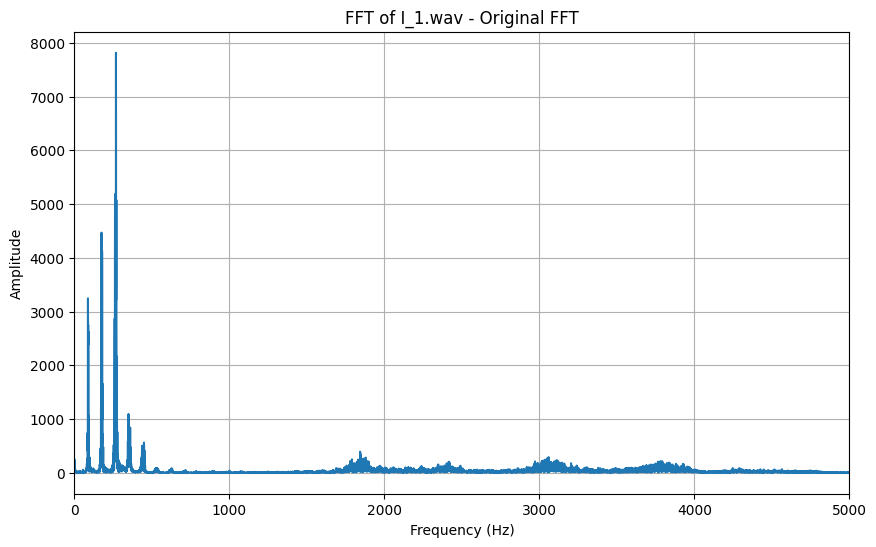

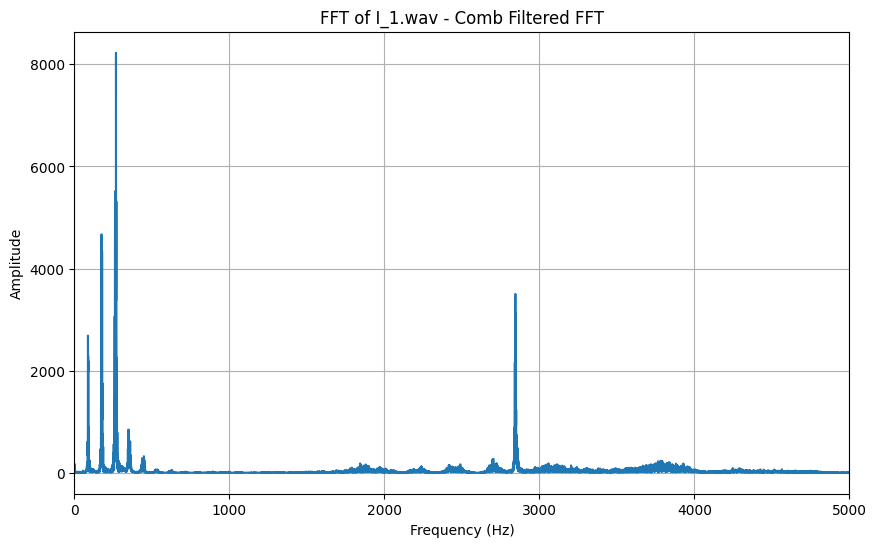

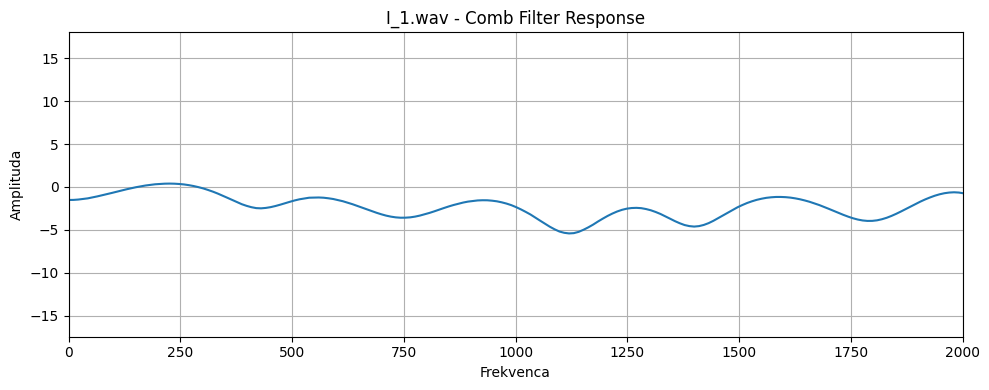

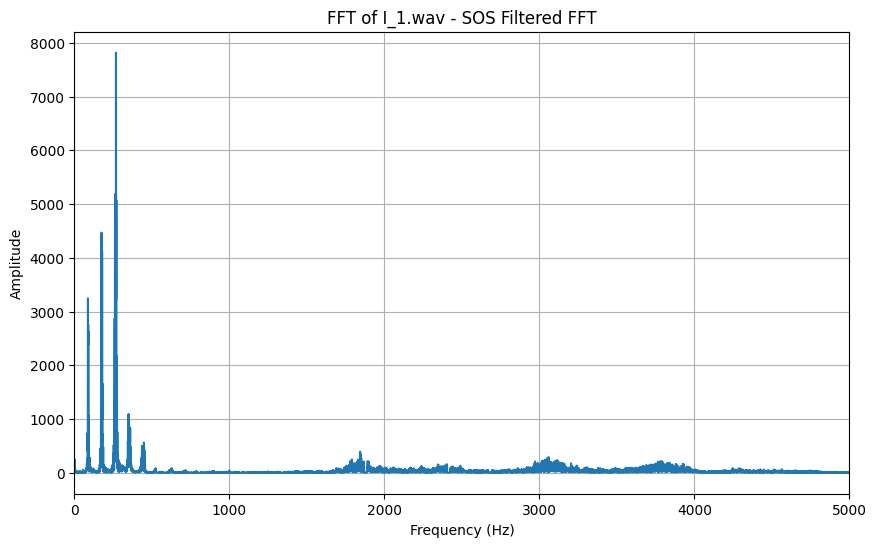

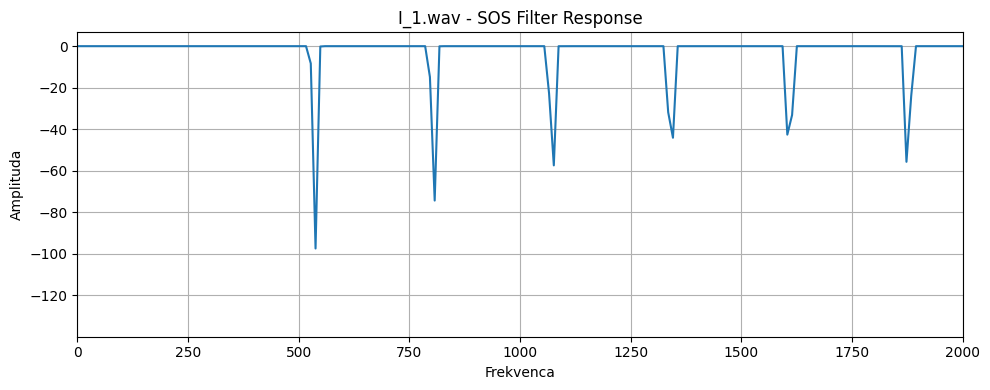

------------------------------------------------------------------------------------------
Najdena bazna frekvenca: 323.75537799631223 Hz


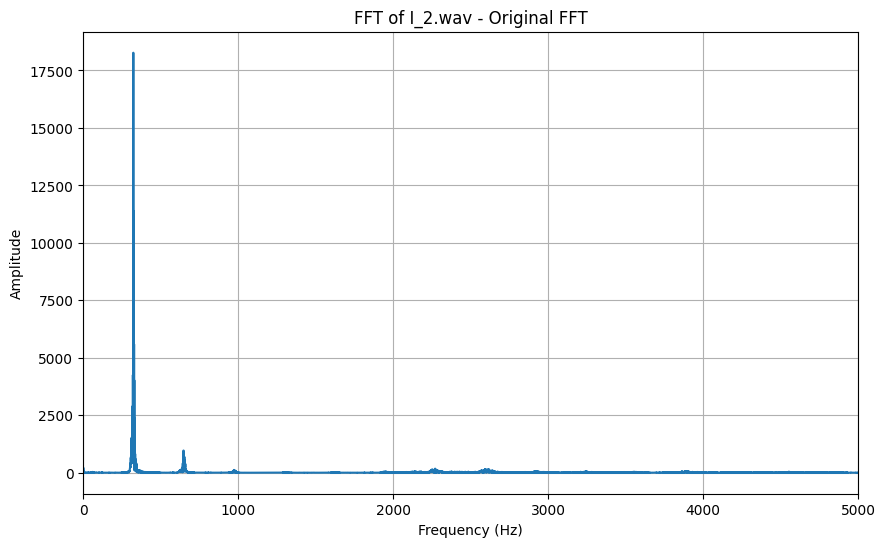

Filter ni stabilen


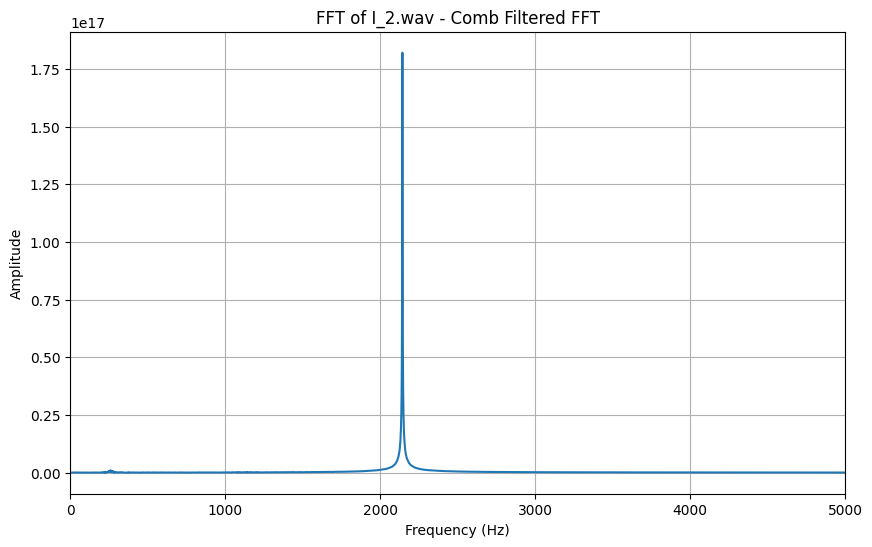

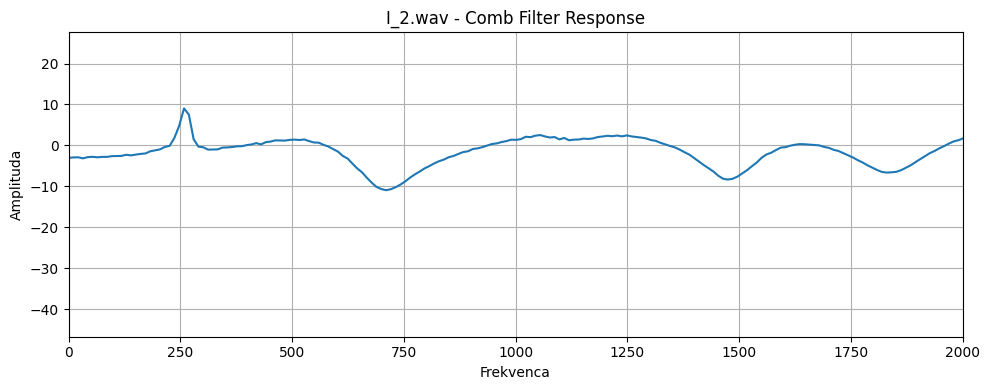

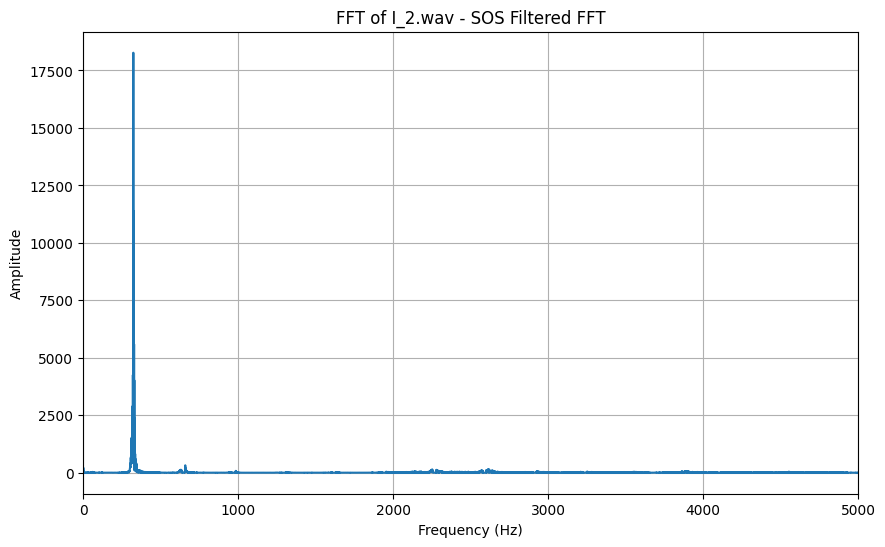

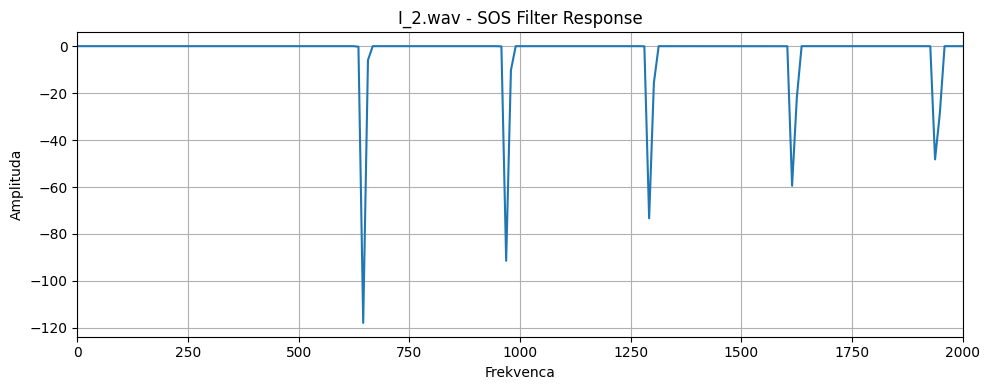

------------------------------------------------------------------------------------------
Najdena bazna frekvenca: 452.96878352284915 Hz


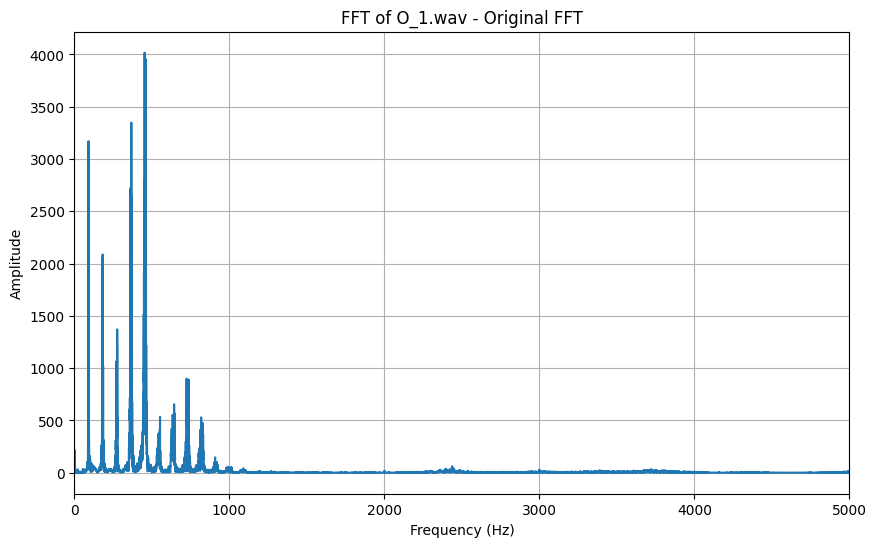

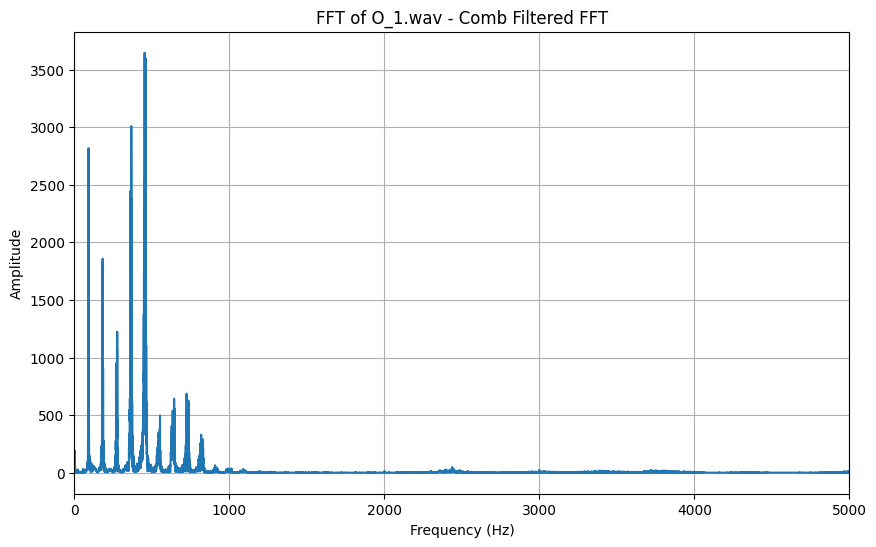

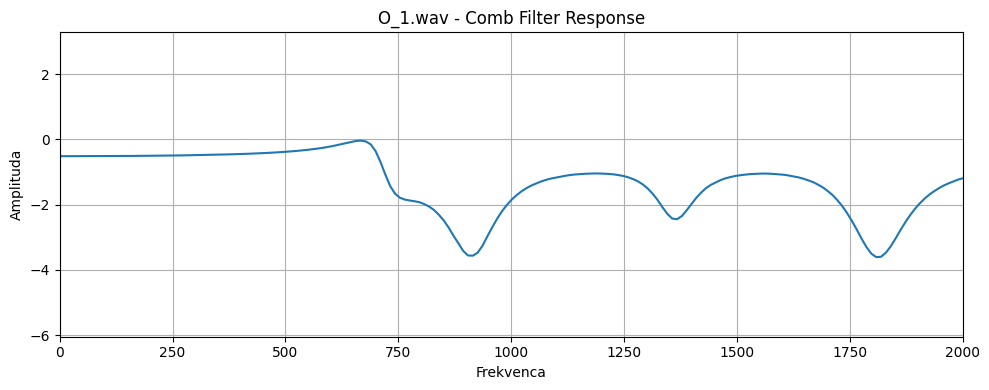

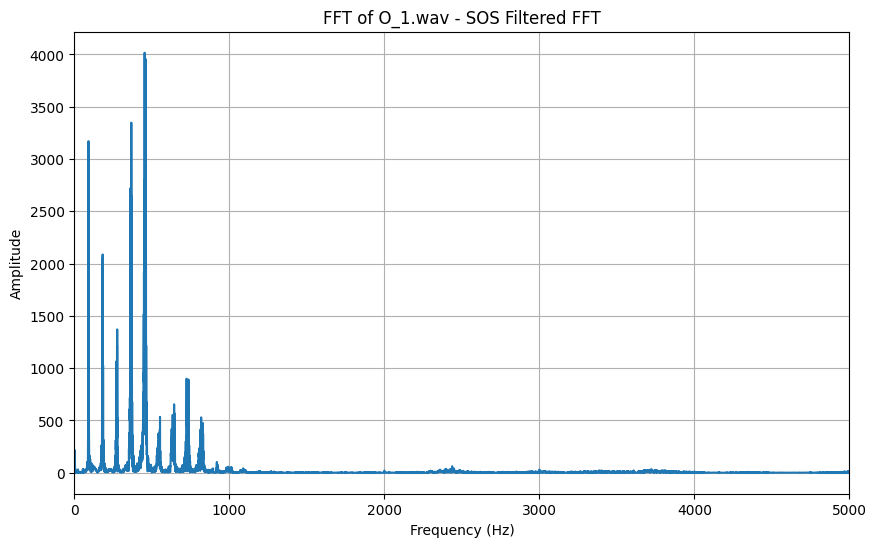

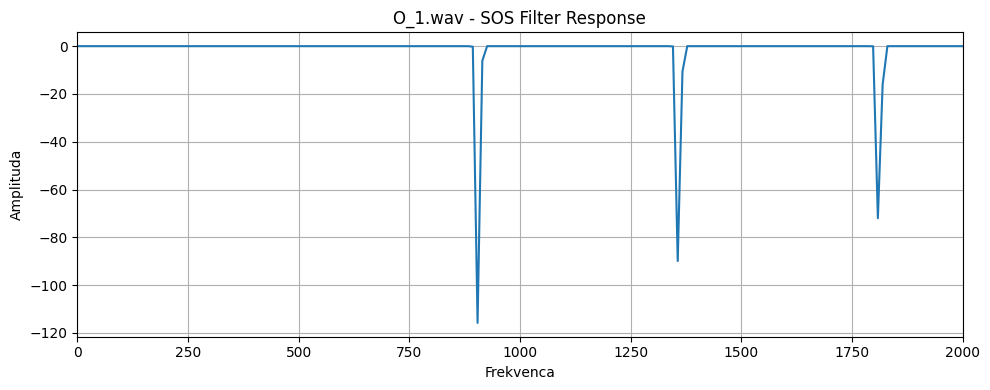

------------------------------------------------------------------------------------------
Najdena bazna frekvenca: 315.36054940862266 Hz


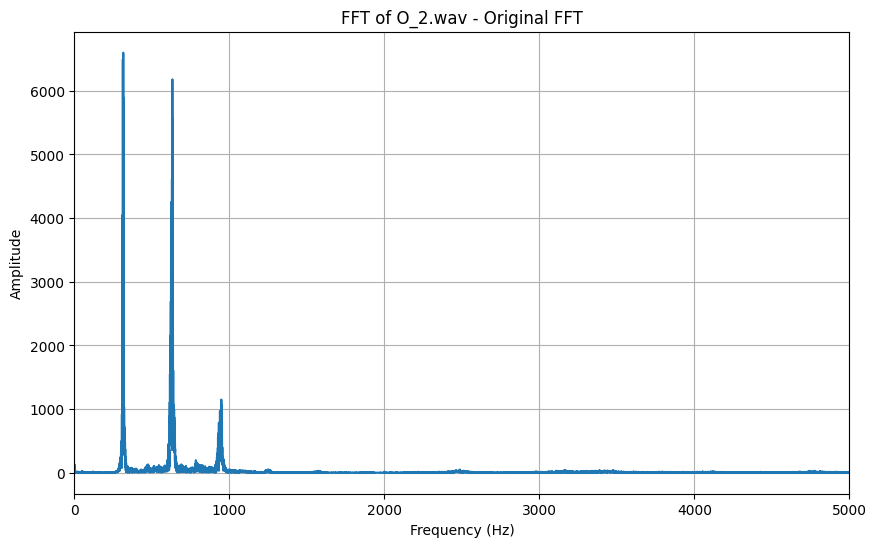

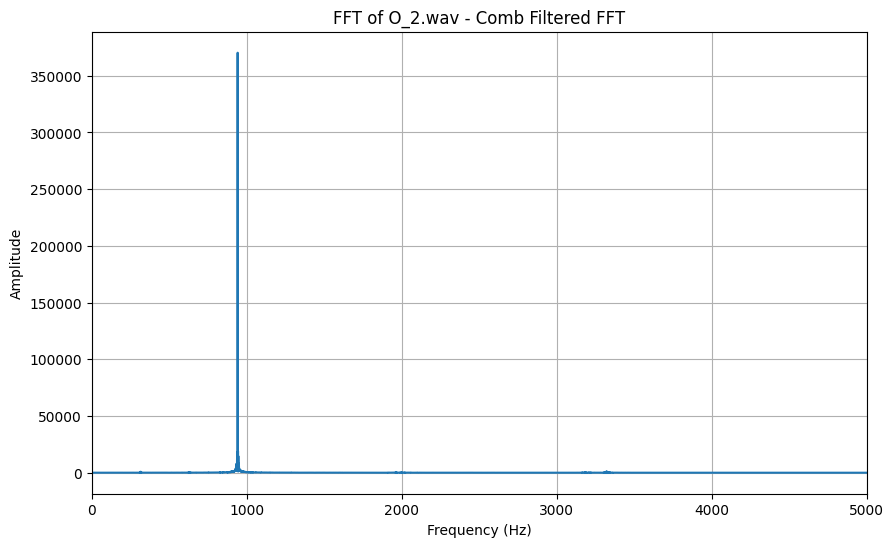

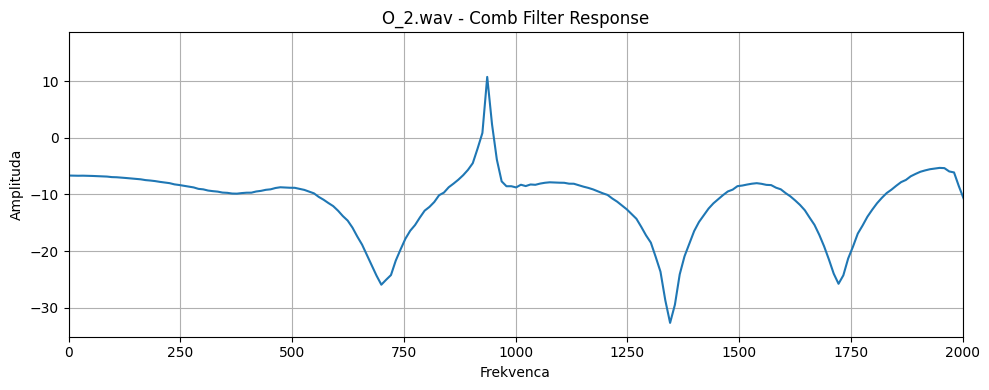

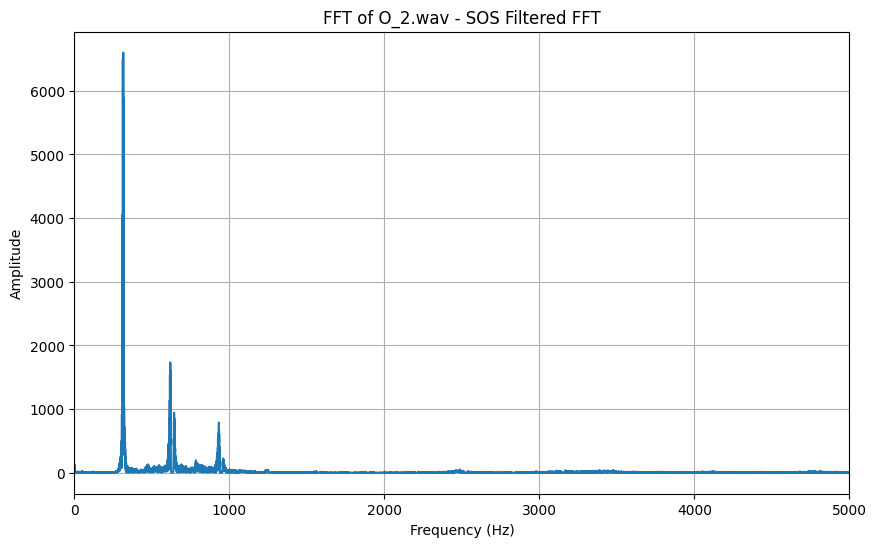

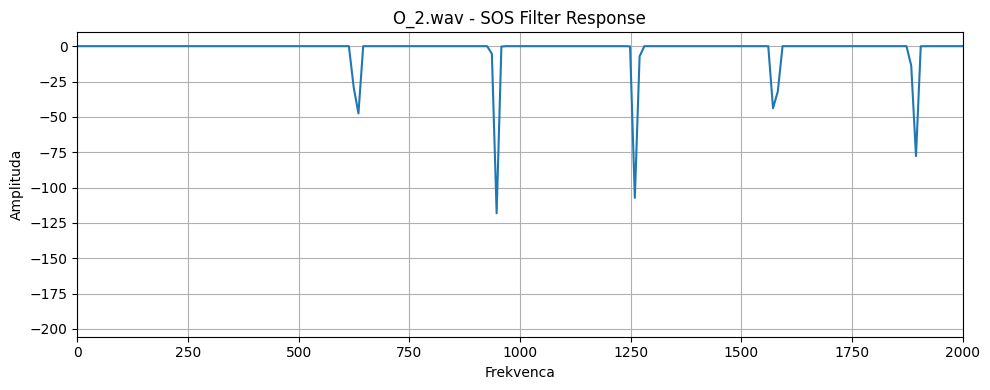

------------------------------------------------------------------------------------------


In [320]:
import os


def procesiraj_signale():
    harmonics = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    folder = 'Audio'
    files = [f for f in os.listdir(folder) if f.lower().endswith('.wav')]

    for filename in files[:]:
        filepath = os.path.join(folder, filename)
        sample_rate, signal = read(filepath)
        y = (signal / np.max(np.abs(signal))).astype(np.float32)

        N = len(signal)
        freqs = np.fft.rfftfreq(N, d=1 / sample_rate)
        amplitudes = np.abs(np.fft.rfft(y))

        f0 = find_fundamental(freqs, amplitudes)
        print(f"Najdena bazna frekvenca: {f0} Hz")

        plot_dft(freqs, amplitudes, f"{filename} - Original FFT")

        # COMB FILTER
        b, a = comb_filter(sample_rate, f0, harmonics, order=40, width=50, min_freq=500)
        y_filt = filtfilt(b, a, y.copy())

        freqs_filt = np.fft.rfftfreq(len(y_filt), d=1 / sample_rate)
        amplitudes_filt = np.abs(np.fft.rfft(y_filt))
        plot_dft(freqs_filt, amplitudes_filt, f"{filename} - Comb Filtered FFT")

        plot_filter_response((b, a), sample_rate, f"{filename} - Comb Filter Response", type="comb")

        # CASCADING FILTER
        sos = cascade_filter(sample_rate, f0, harmonics, order=7, width=10)
        y_sos_filt = sosfiltfilt(sos, y.copy())
        freqs_sos_filt = np.fft.rfftfreq(len(y_sos_filt), d=1 / sample_rate)
        amplitudes_sos_filt = np.abs(np.fft.rfft(y_sos_filt))
        plot_dft(freqs_sos_filt, amplitudes_sos_filt, f"{filename} - SOS Filtered FFT")

        plot_filter_response(sos, sample_rate, f"{filename} - SOS Filter Response", type="cascade")

        print("---" * 30)




procesiraj_signale()